In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

#from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set_context("poster", font_scale=1.3)

import missingno as msno
import pandas_profiling

from sklearn.datasets import make_blobs
import time

In [2]:
def save_subgroup(dataframe, g_index, subgroup_name, prefix='raw_'):
    save_subgroup_filename = "".join([prefix, subgroup_name, ".csv.gz"])
    dataframe.to_csv(save_subgroup_filename, compression='gzip', encoding='UTF-8')
    test_df = pd.read_csv(save_subgroup_filename, compression='gzip', index_col=g_index, encoding='UTF-8')
    # Test that we recover what we send in
    if dataframe.equals(test_df):
        print("Test-passed: we recover the equivalent subgroup dataframe.")
    else:
        print("Warning -- equivalence test!!! Double-check.")

In [3]:
def load_subgroup(filename, index_col=[0]):
    return pd.read_csv(filename, compression='gzip', index_col=index_col)

## Players

In [4]:
# players = load_subgroup("../data/redcard/raw_players.csv.gz")
players = load_subgroup("raw_players.csv.gz")

In [5]:
players.head()

,birthday,height,weight,position,photoID,rater1,rater2
playerShort,,,,,,,
aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.00
aaron-hunt,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,0.00,0.25
aaron-lennon,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,0.25,0.25
aaron-ramsey,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,0.00,0.00
abdelhamid-el-kaoutari,17.03.1990,180.0,73.0,Center Back,124913.jpg,0.25,0.25


In [6]:
players.shape

(2053, 7)

In [7]:
print(players.sample(500))

                         birthday  height  weight              position  \
playerShort                                                               
barragan_3             12.06.1987   187.0    83.0        Right Fullback   
jamie-ness             02.03.1991   177.0     NaN                   NaN   
gueida-fofana          16.05.1991   182.0    74.0                   NaN   
robert-hall            20.10.1993   173.0    66.0                   NaN   
hugo-rodallega         25.07.1985   181.0    72.0        Center Forward   
cristian-tello         11.08.1991   178.0    65.0           Left Winger   
branimir-hrgota        12.01.1993   185.0    74.0                   NaN   
biel-company           16.02.1992   176.0    73.0                   NaN   
fabien-audard          28.03.1978   188.0    89.0            Goalkeeper   
zakarie-labidi         08.02.1995   178.0    71.0                   NaN   
ramalho_4              10.06.1993   181.0    68.0           Center Back   
raul_10                13

## Visualize the missing-ness of data

https://github.com/ResidentMario/missingno

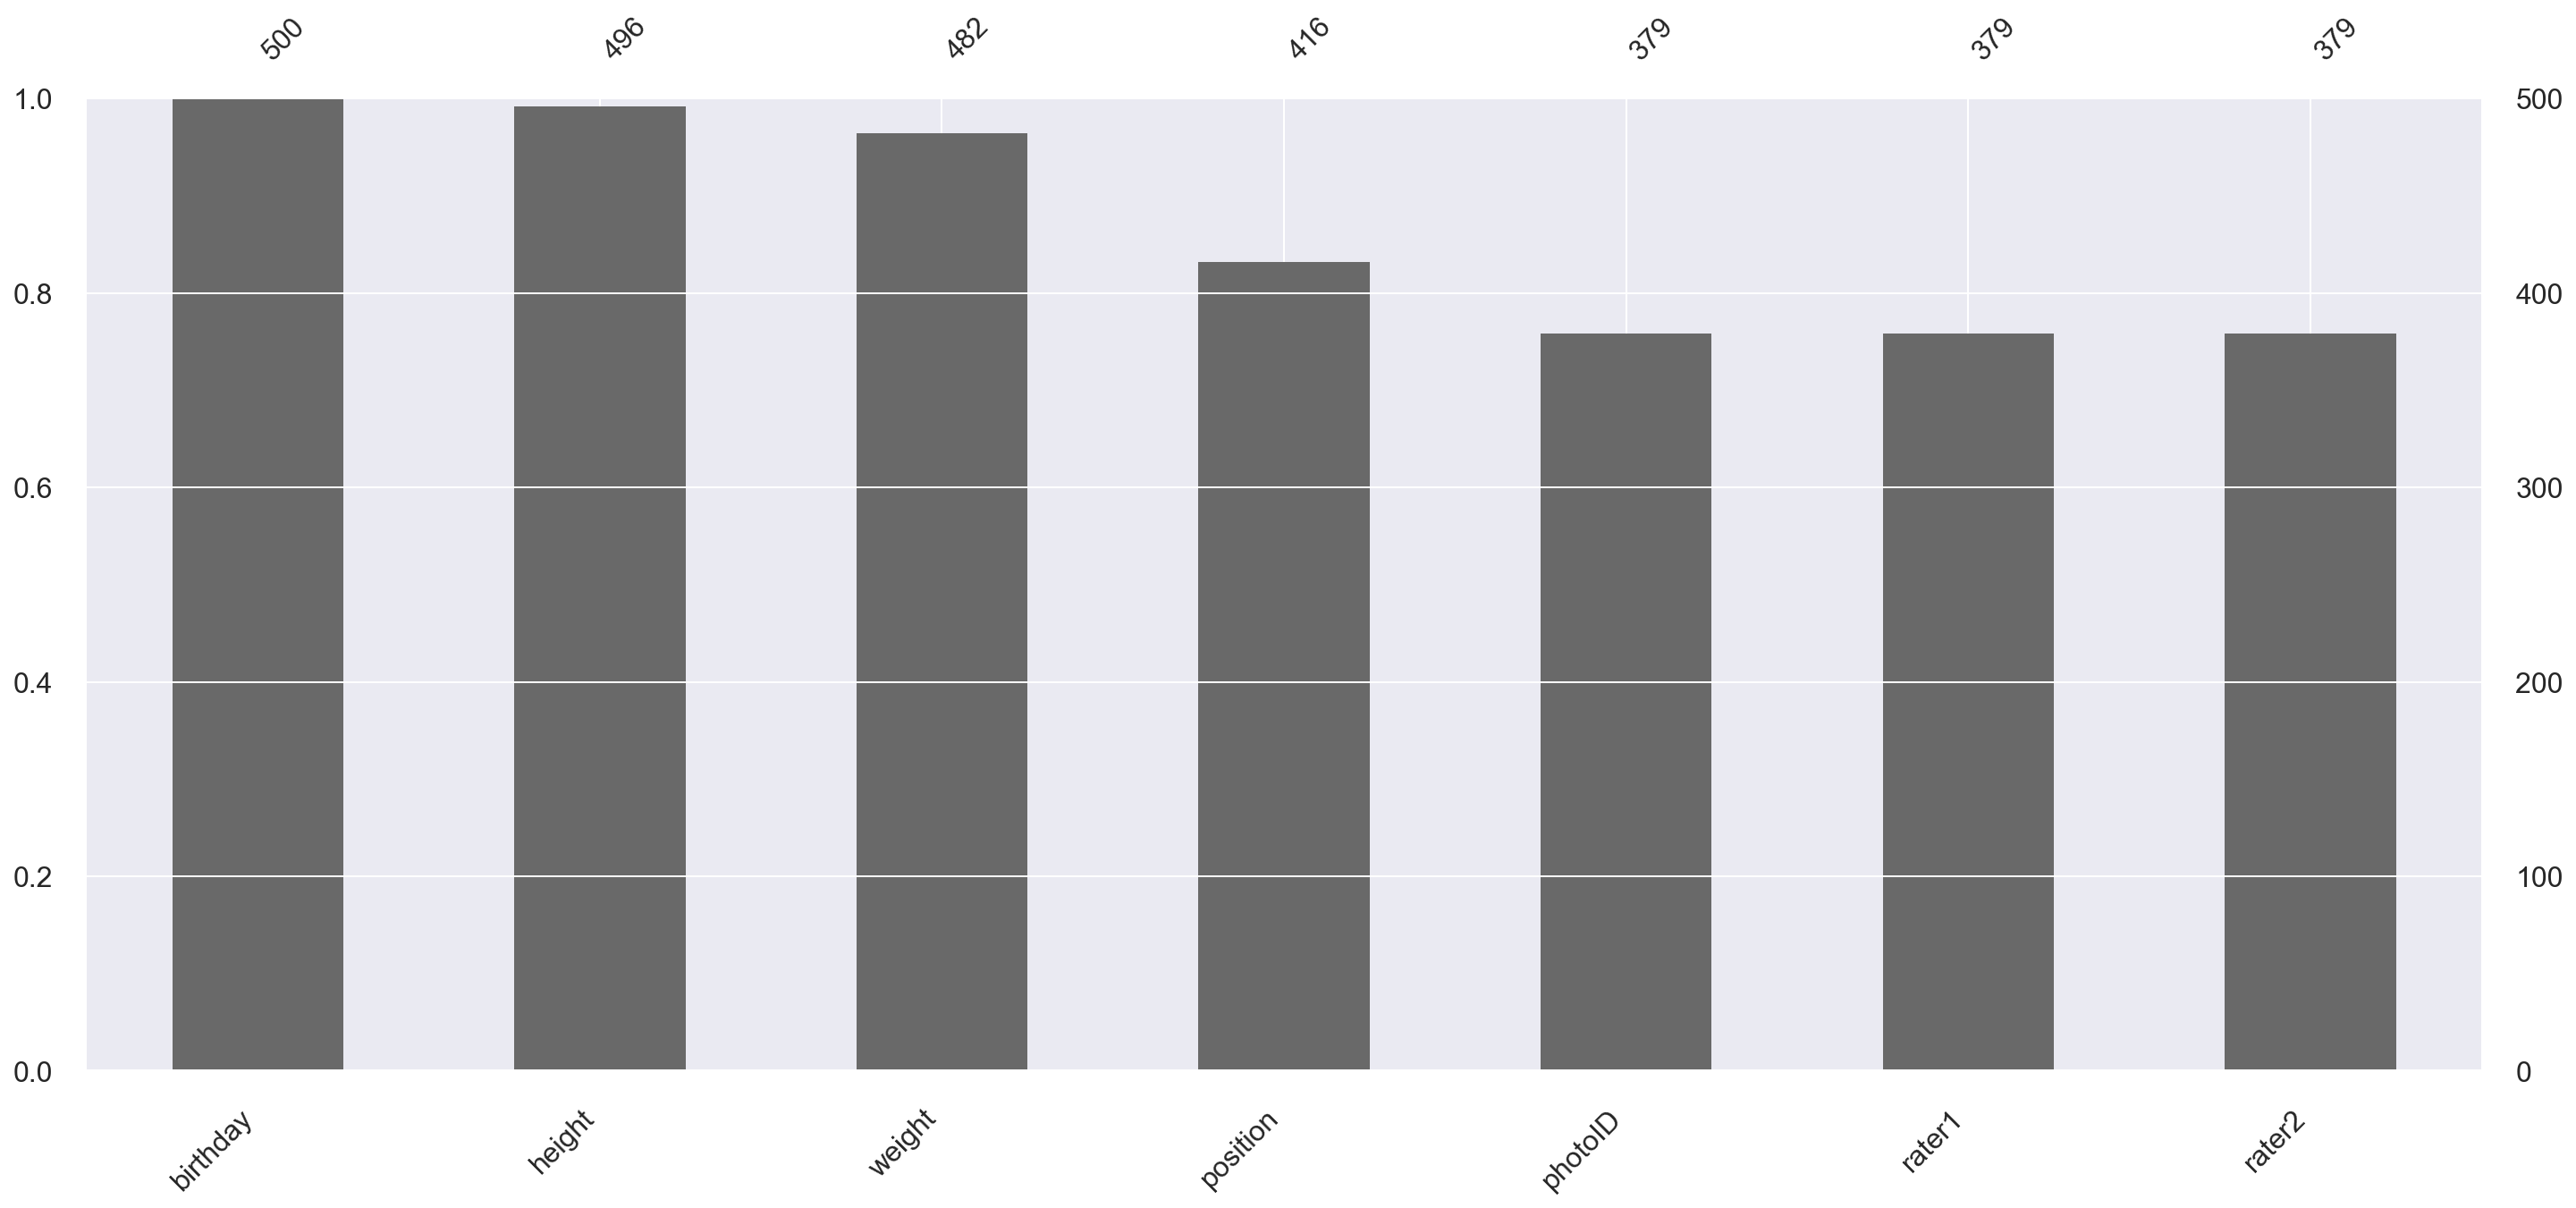

In [8]:
msno.bar(players.sample(500))

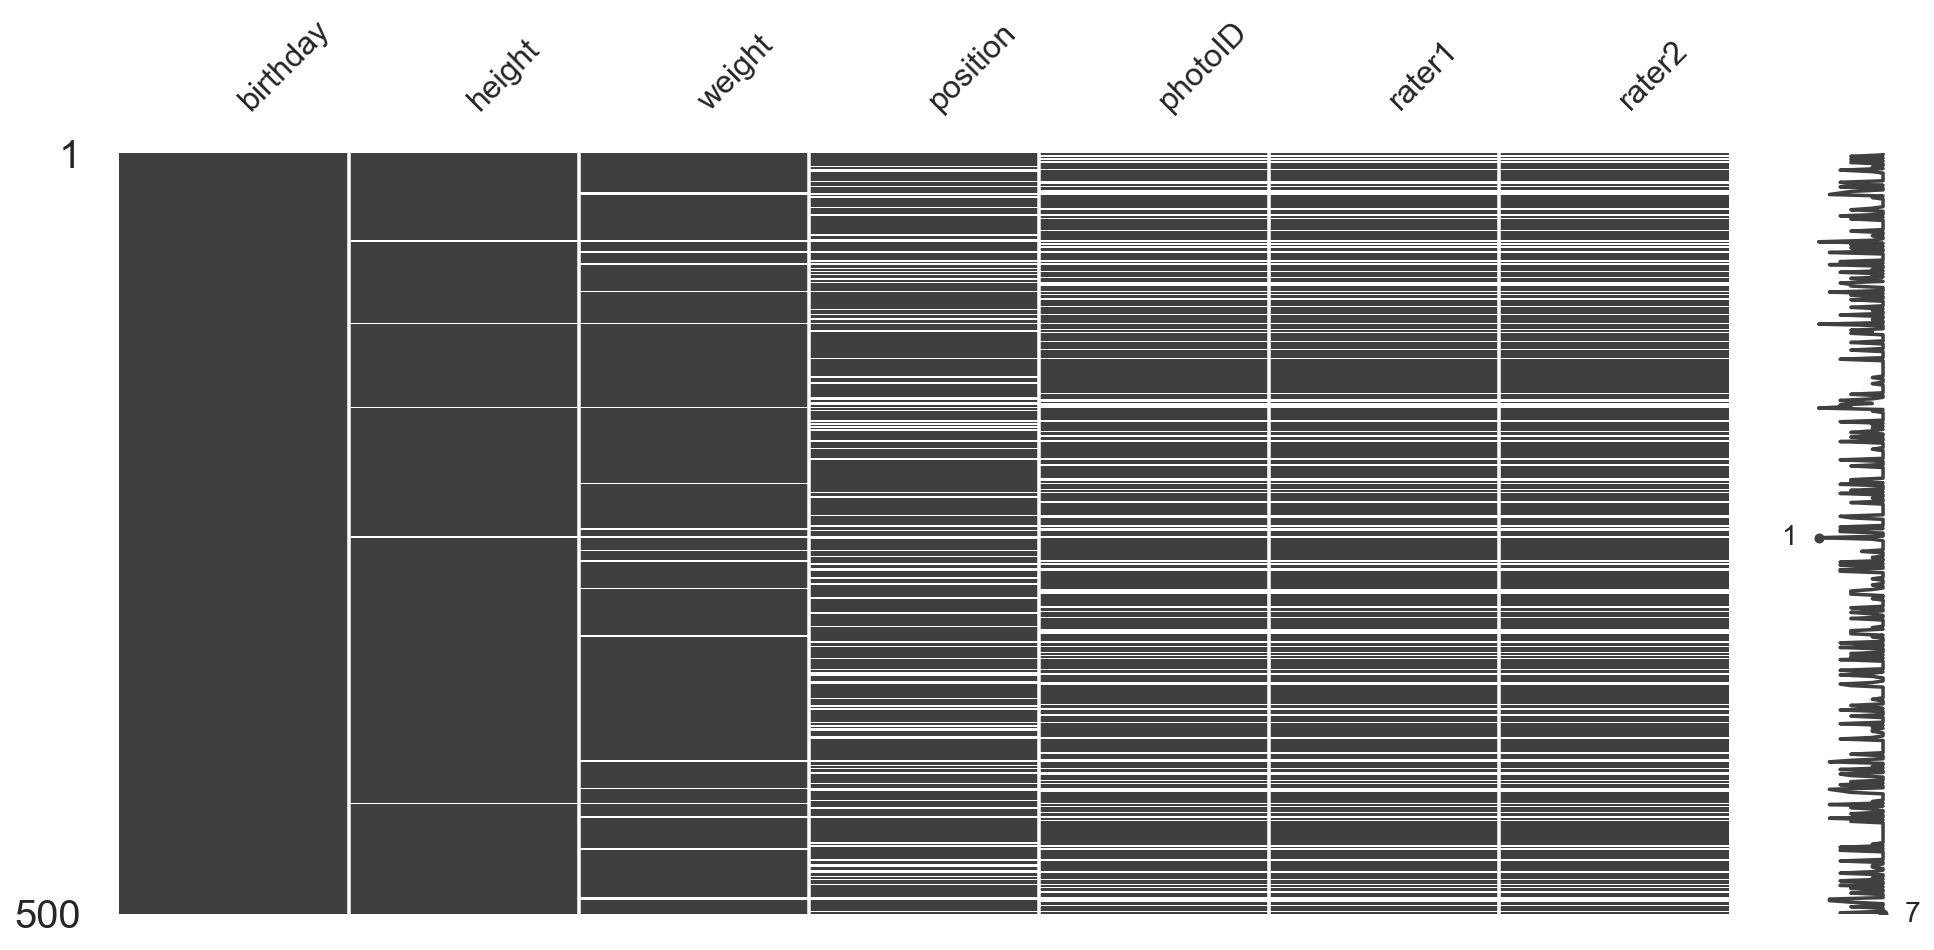

In [9]:
msno.matrix(players.sample(500),
            figsize=(16, 7),
            width_ratios=(15, 1))

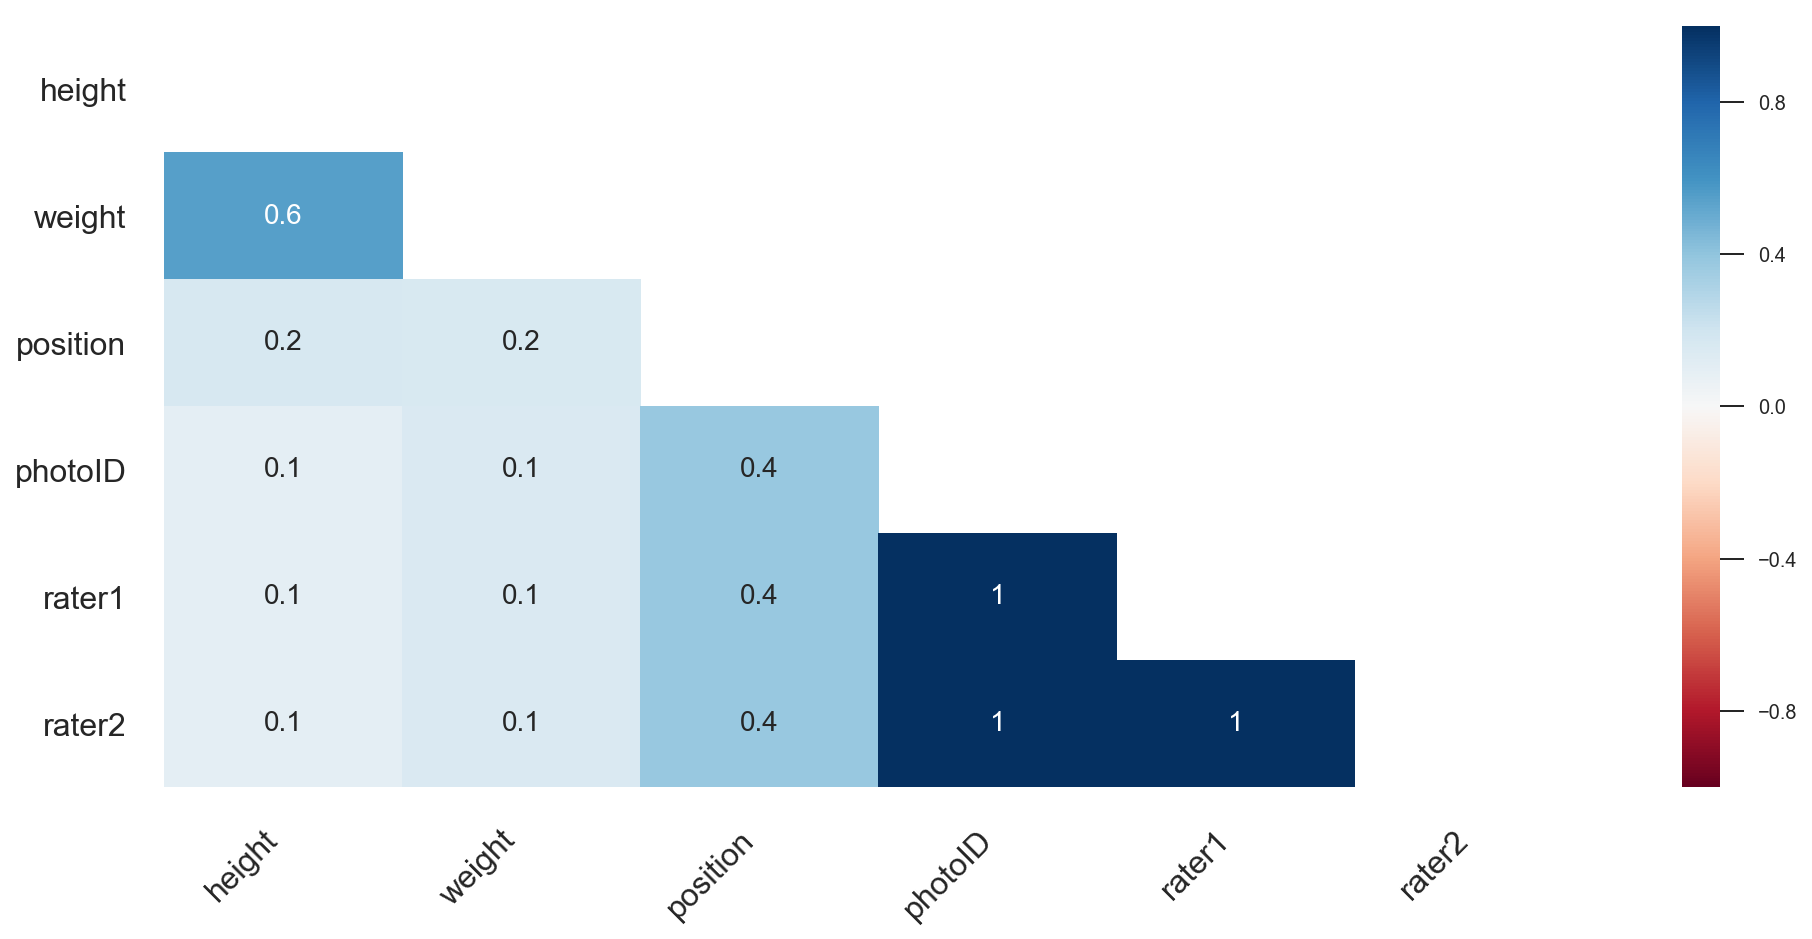

In [10]:
msno.heatmap(players.sample(500),
            figsize=(16, 7),)

ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).

In [11]:
print("All players:", len(players))
print("rater1 nulls:", len(players[(players.rater1.isnull())]))
print("rater2 nulls:", len(players[players.rater2.isnull()]))
print("Both nulls:", len(players[(players.rater1.isnull()) & (players.rater2.isnull())]))

All players: 2053
rater1 nulls: 468
rater2 nulls: 468
Both nulls: 468


In [12]:
# modifying dataframe
players = players[players.rater1.notnull()]
players.shape[0]

1585

In [13]:
2053-1585

468

We've removed 468 players from the table who had no skintone rating.

Let's look again at the missing data in this table. 

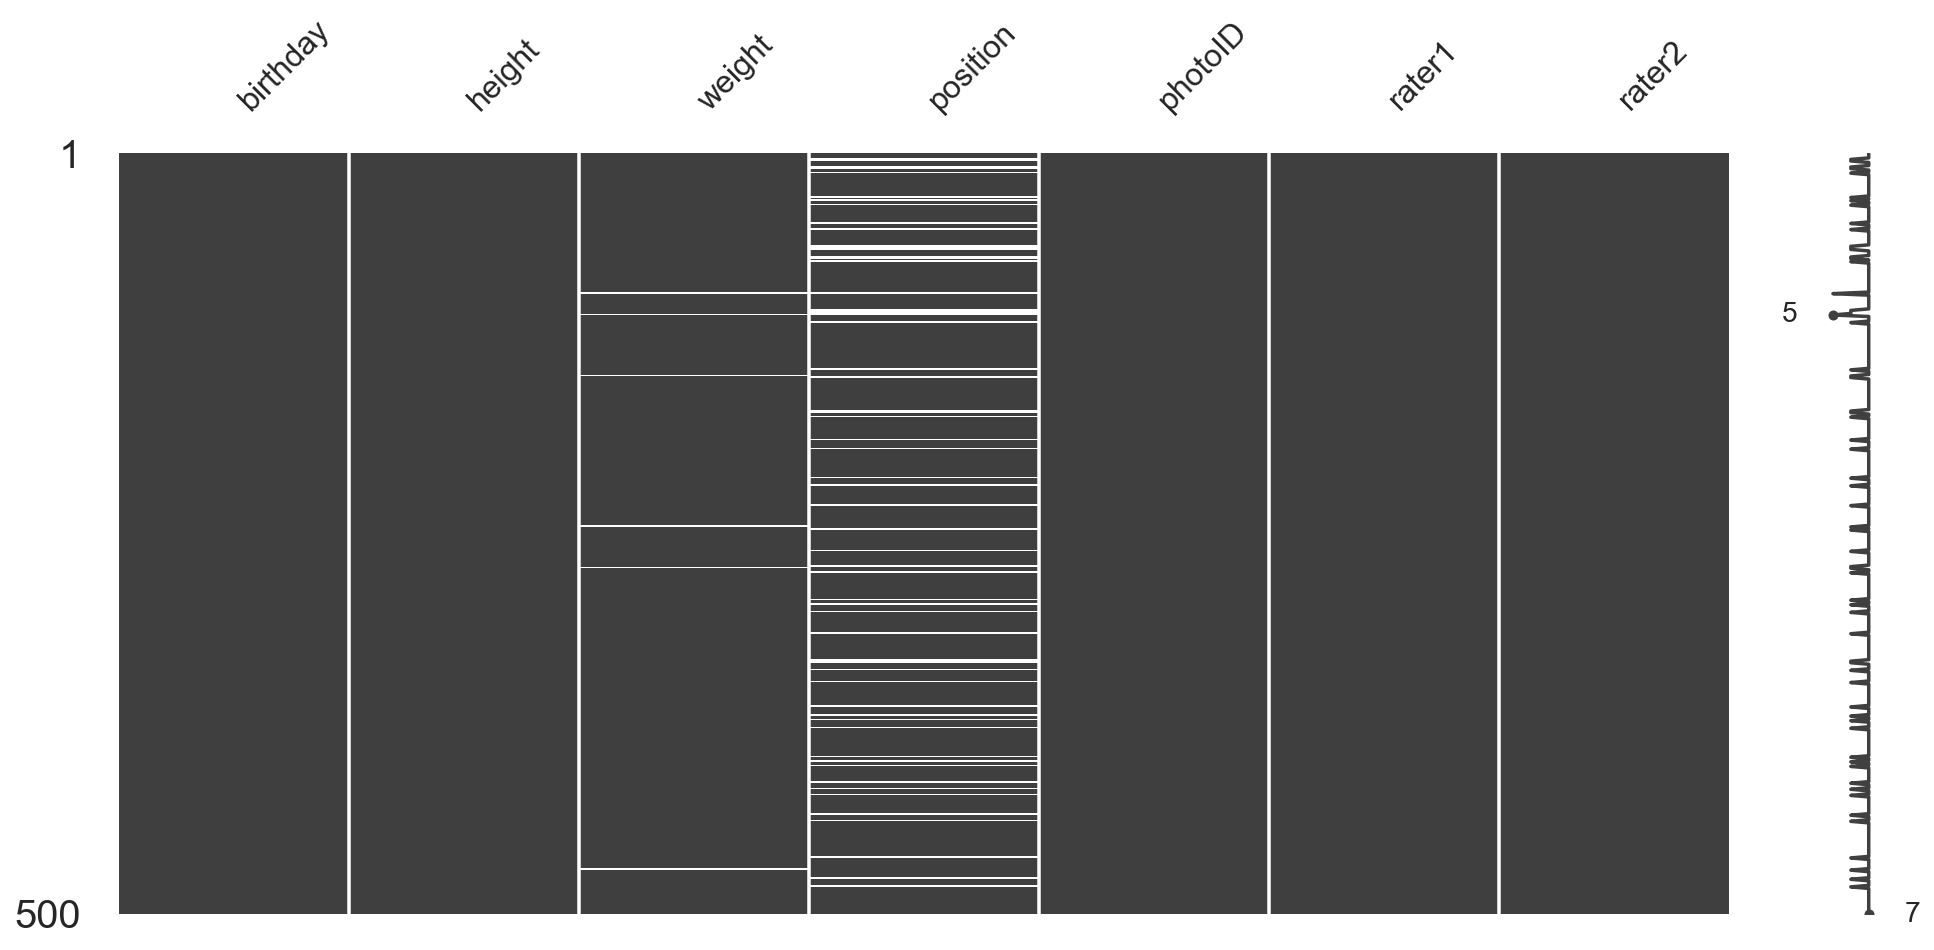

In [14]:
msno.matrix(players.sample(500),
            figsize=(16, 7),
            width_ratios=(15, 1))

Each remaining player in the table has 2 skintone ratings -- are they sufficiently close that they can be combined?

In [15]:
pd.crosstab(players.rater1, players.rater2)

rater2,0.0,0.25,0.5,0.75,1.0
rater1,,,,,
0.00,424,200,2,0,0
0.25,27,470,54,0,0
0.50,0,23,116,31,0
0.75,0,0,2,104,34
1.00,0,0,0,6,92


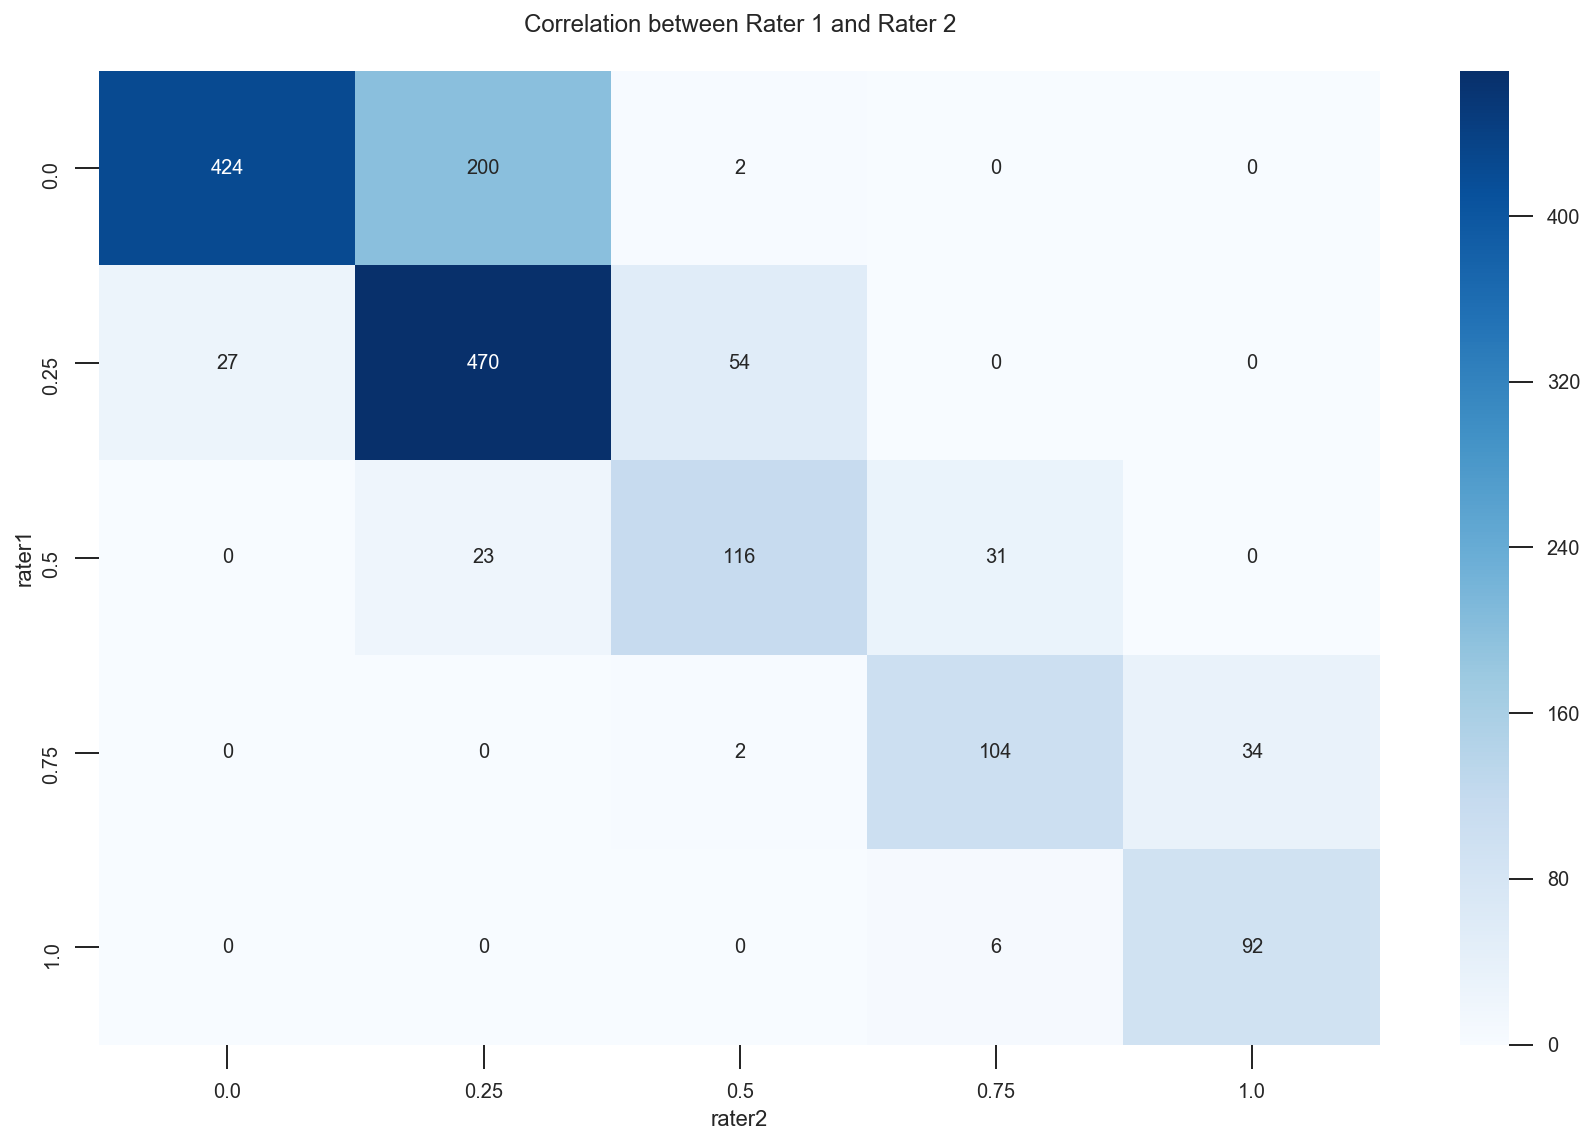

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pd.crosstab(players.rater1, players.rater2), cmap='Blues', annot=True, fmt='d', ax=ax)
ax.set_title("Correlation between Rater 1 and Rater 2\n")
fig.tight_layout()

### Create useful new columns

This looks correlated enough to me -- let's combine the rater's skintone ratings into a new column that is the average rating. 

In [17]:
players.head()

,birthday,height,weight,position,photoID,rater1,rater2
playerShort,,,,,,,
aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.00
aaron-hunt,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,0.00,0.25
aaron-lennon,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,0.25,0.25
aaron-ramsey,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,0.00,0.00
abdelhamid-el-kaoutari,17.03.1990,180.0,73.0,Center Back,124913.jpg,0.25,0.25


In [18]:
# modifying dataframe
players['skintone'] = players[['rater1', 'rater2']].mean(axis=1)
players.head()

,birthday,height,weight,position,photoID,rater1,rater2,skintone
playerShort,,,,,,,,
aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.00,0.125
aaron-hunt,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,0.00,0.25,0.125
aaron-lennon,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,0.25,0.25,0.250
aaron-ramsey,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,0.00,0.00,0.000
abdelhamid-el-kaoutari,17.03.1990,180.0,73.0,Center Back,124913.jpg,0.25,0.25,0.250


## Visualize distributions of univariate features

What is the skintone distribution?

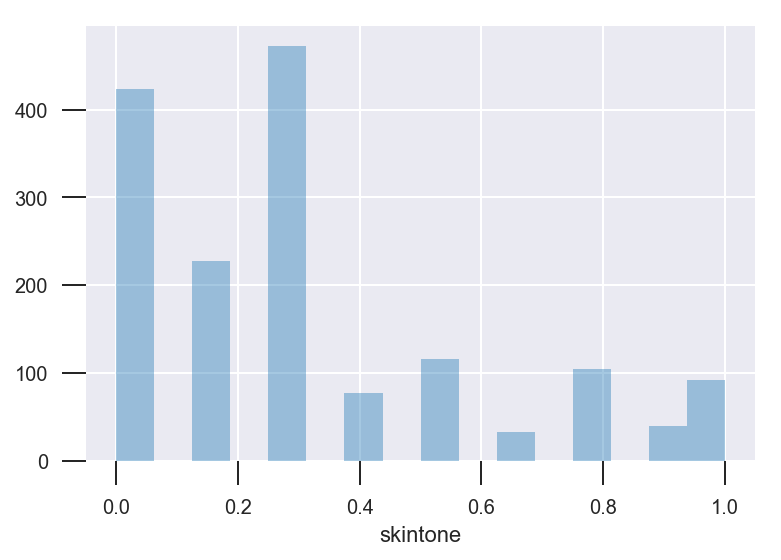

In [19]:
sns.distplot(players.skintone, kde=False);

## Positions

Might the player's position correlate with the baseline susceptibility to redcards? Likely that a defender would have a higher rate than a keeper, for example. 

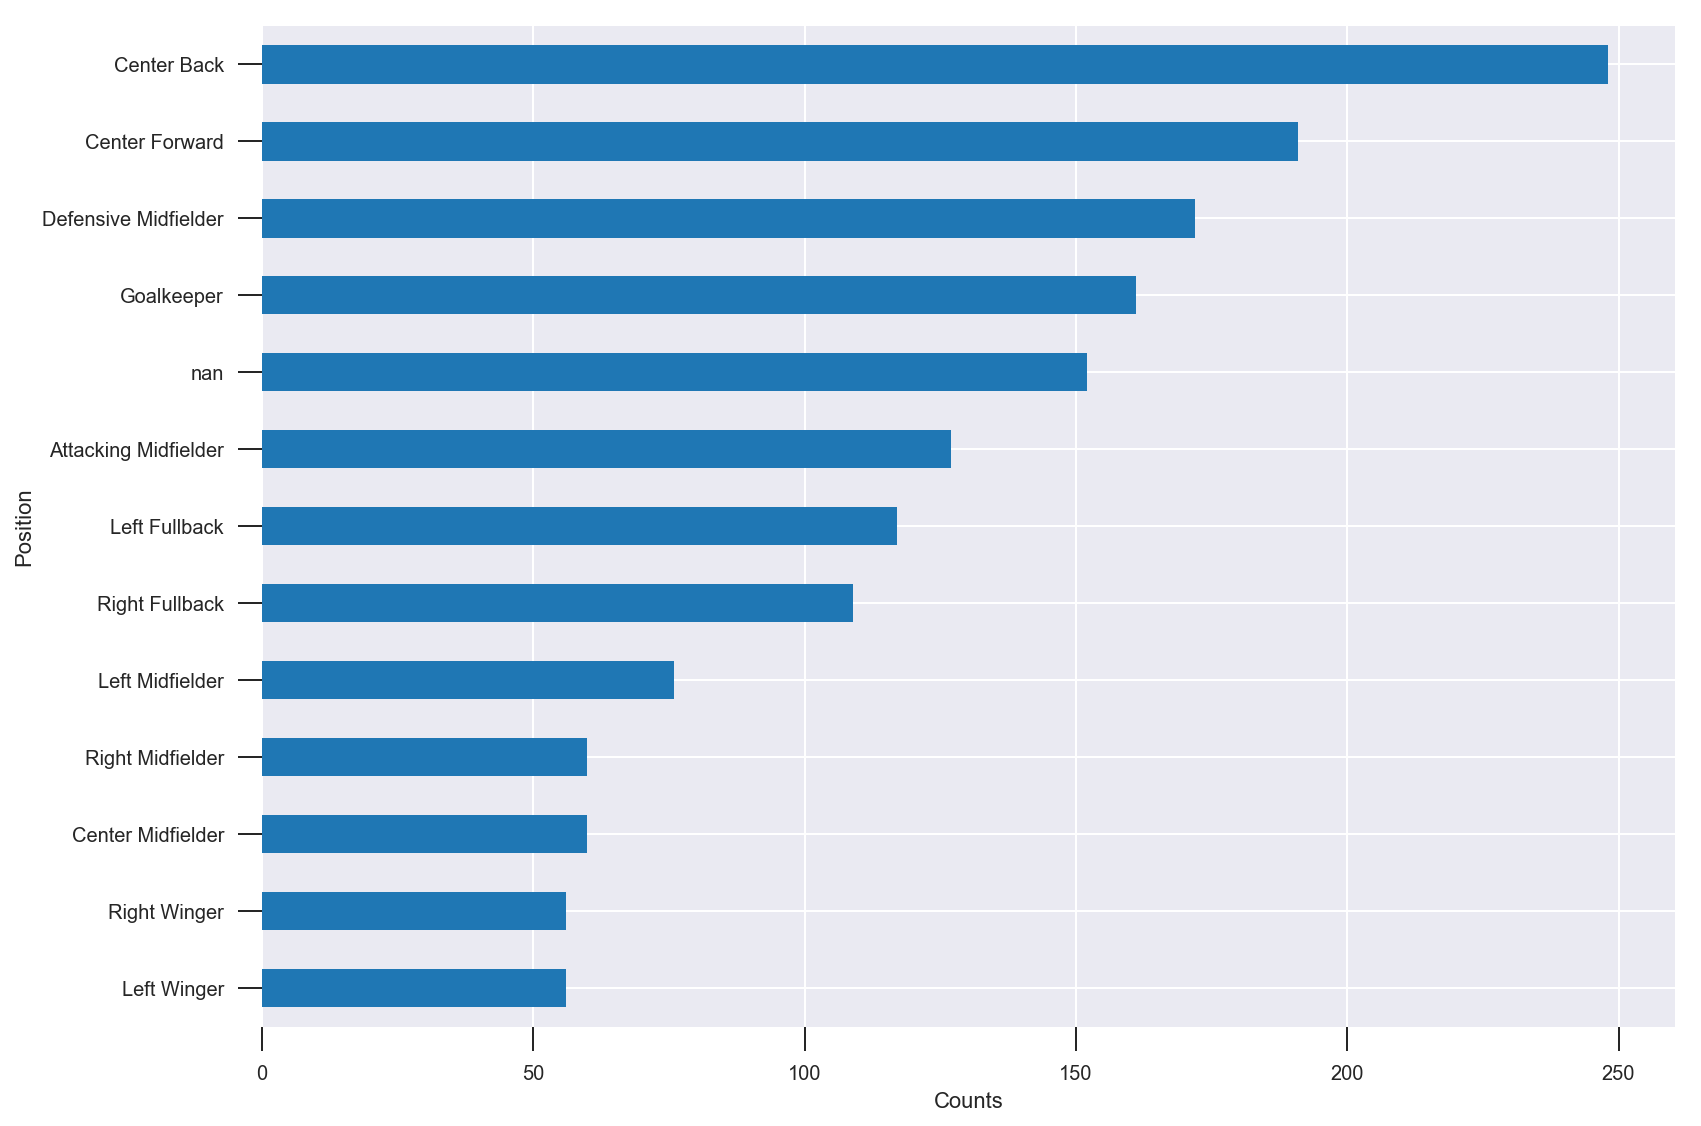

In [20]:
MIDSIZE = (12, 8)
fig, ax = plt.subplots(figsize=MIDSIZE)
players.position.value_counts(dropna=False, ascending=True).plot(kind='barh', ax=ax)
ax.set_ylabel("Position")
ax.set_xlabel("Counts")
fig.tight_layout()

### Create higher level categories

Intuitively, the different positions in the field probably have different redcard rates, but we have data that's very granular. 

Recommendation: 

 - create a new column
 - Don't overwrite the original data in case you need it or decide later that the higher level category is not useful

I chose to split up the position types by their primary roles (you can disagree with my categorization and do it differently if you feel). 

In [21]:
position_types = players.position.unique()
position_types

array(['Center Back', 'Attacking Midfielder', 'Right Midfielder',
       'Center Midfielder', 'Goalkeeper', 'Defensive Midfielder',
       'Left Fullback', nan, 'Left Midfielder', 'Right Fullback',
       'Center Forward', 'Left Winger', 'Right Winger'], dtype=object)

In [22]:
defense = ['Center Back','Defensive Midfielder', 'Left Fullback', 'Right Fullback', ]
midfield = ['Right Midfielder', 'Center Midfielder', 'Left Midfielder',]
forward = ['Attacking Midfielder', 'Left Winger', 'Right Winger', 'Center Forward']
keeper = 'Goalkeeper'

# modifying dataframe -- adding the aggregated position categorical position_agg
players.loc[players['position'].isin(defense), 'position_agg'] = "Defense"
players.loc[players['position'].isin(midfield), 'position_agg'] = "Midfield"
players.loc[players['position'].isin(forward), 'position_agg'] = "Forward"
players.loc[players['position'].eq(keeper), 'position_agg'] = "Keeper"

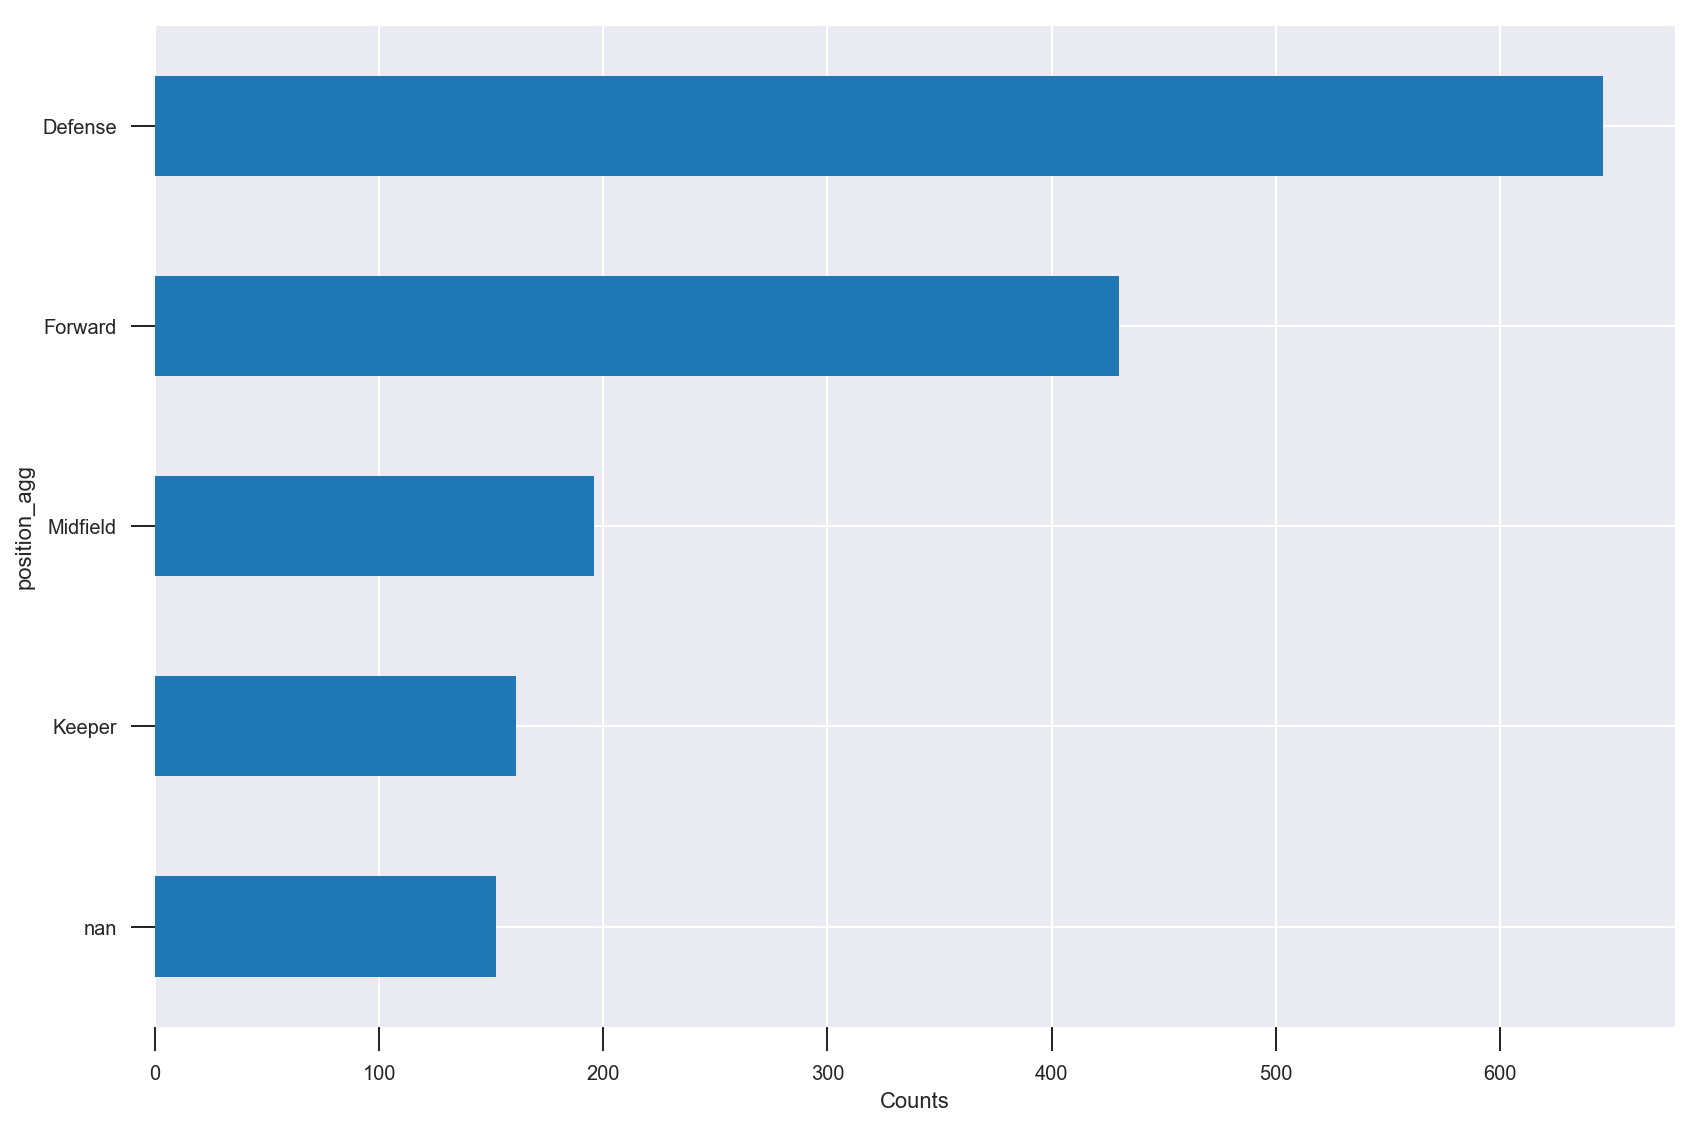

In [23]:
MIDSIZE = (12, 8)
fig, ax = plt.subplots(figsize=MIDSIZE)
players['position_agg'].value_counts(dropna=False, ascending=True).plot(kind='barh', ax=ax)
ax.set_ylabel("position_agg")
ax.set_xlabel("Counts")
fig.tight_layout()

## Examine pair-wise relationships

Take a look at measures that will let you quickly see if there are problems or opportunities in the data.

In [26]:
from pandas.plotting import scatter_matrix

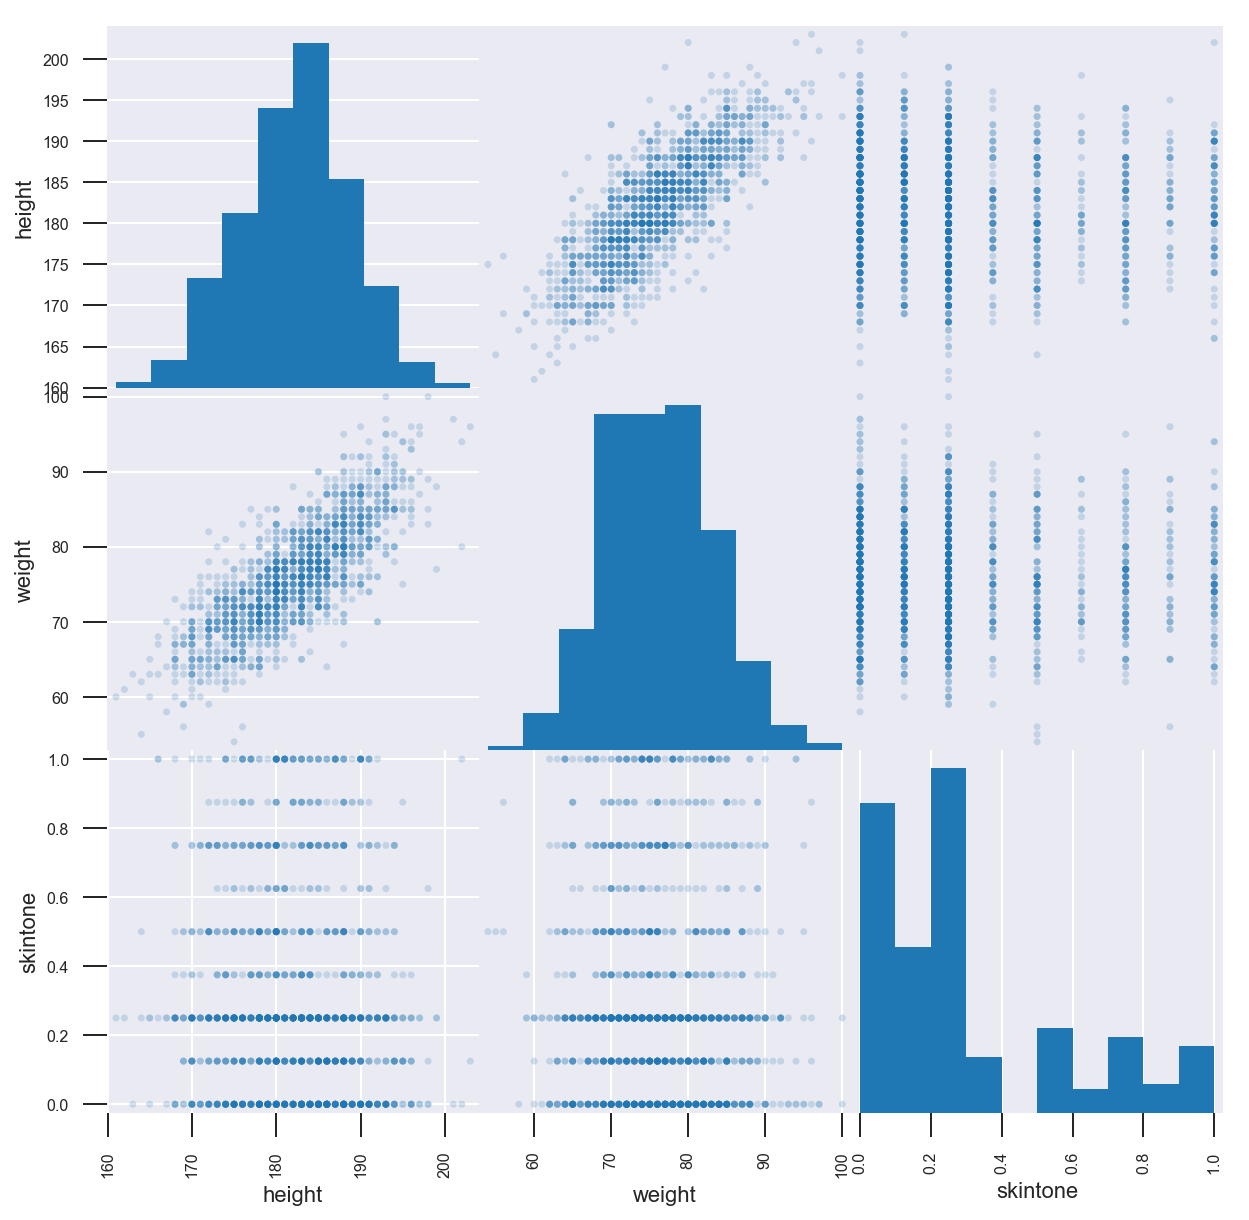

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter_matrix(players[['height', 'weight', 'skintone']], alpha=0.2, diagonal='hist', ax=ax);

In [73]:
# Perhaps you want to see a particular relationship more clearly

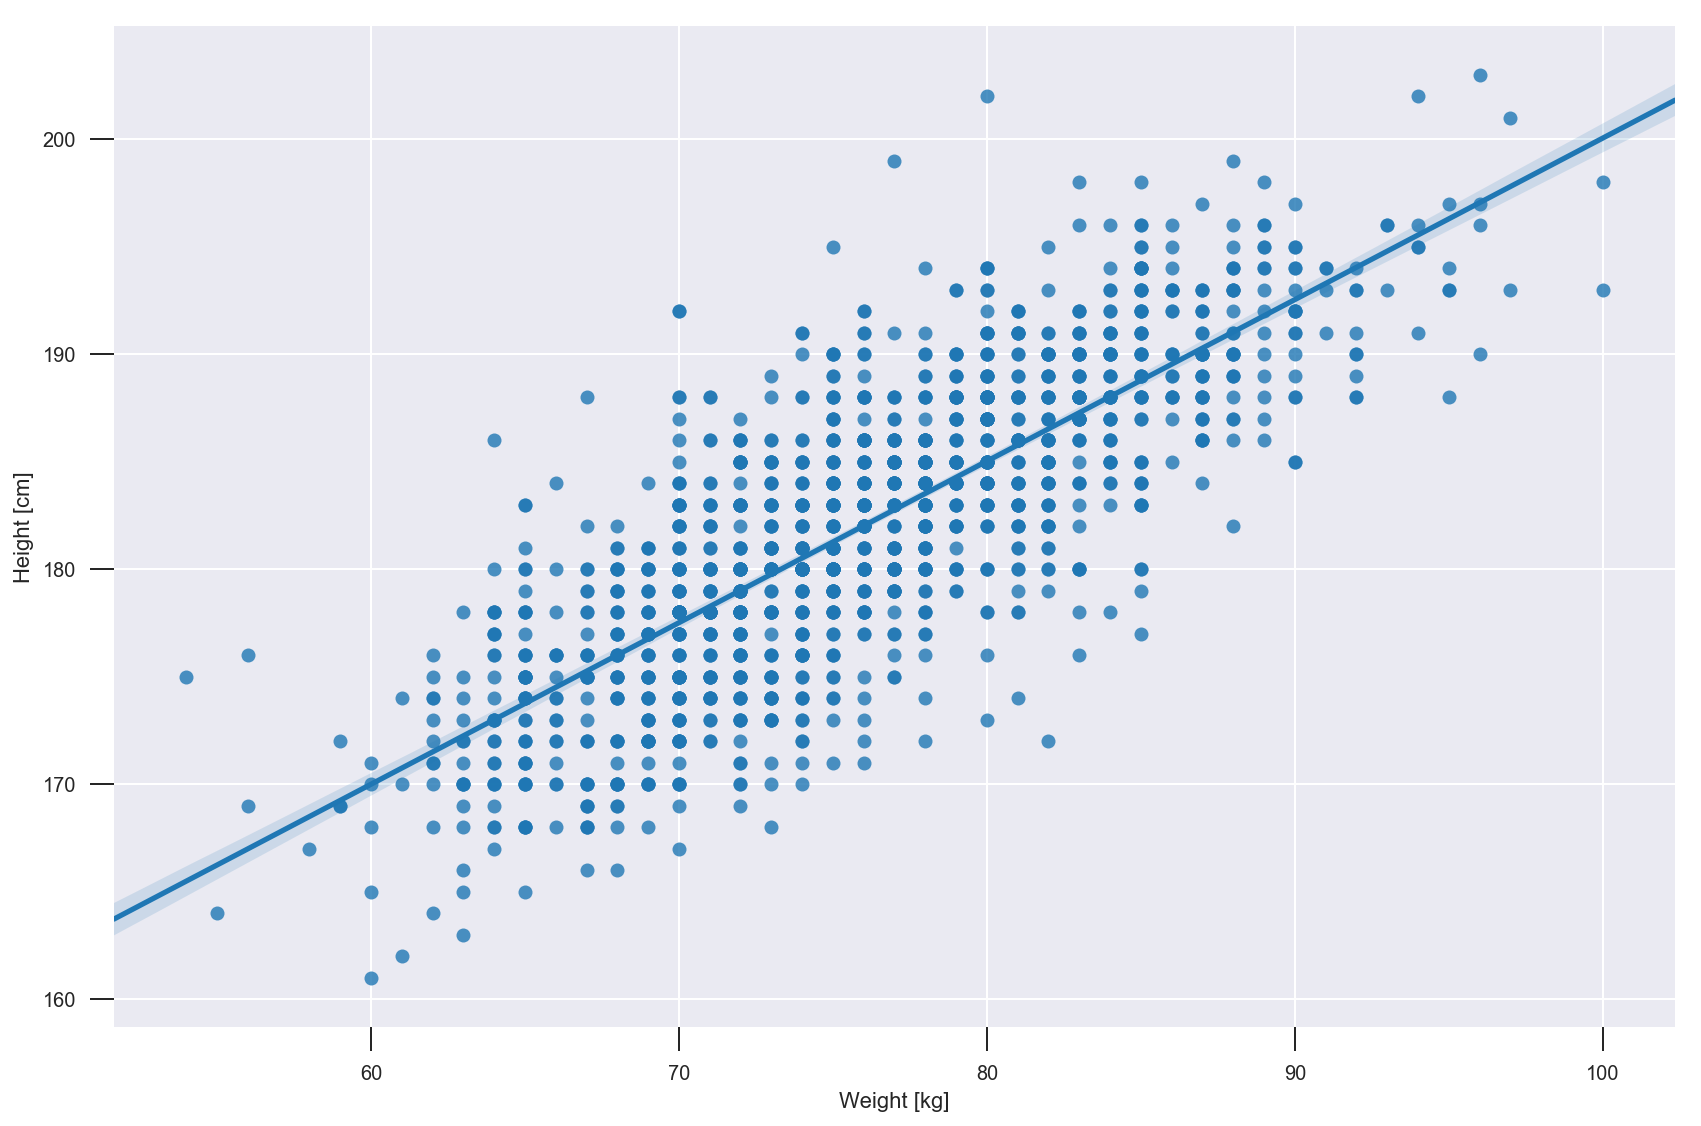

In [28]:
fig, ax = plt.subplots(figsize=MIDSIZE)
sns.regplot('weight', 'height', data=players, ax=ax)
ax.set_ylabel("Height [cm]")
ax.set_xlabel("Weight [kg]")
fig.tight_layout()

There aren't obvious outliers in the height vs weight relationship. Things that I check for: 

 - Are there zeros?
 - Are there strange correlations?
 - Are there separate clusters (something that could come from recording the height in inches for some and in cm for others, for example)?
 


## Create quantile bins for continuous variables

In [33]:
weight_categories = ["vlow_weight",
                     "low_weight",
                     "mid_weight",
                     "high_weight",
                     "vhigh_weight",
                    ]

players['weightclass'] = pd.qcut(players['weight'],
                                 len(weight_categories),
                                 weight_categories)

In [34]:
players.head()

,birthday,height,weight,position,photoID,rater1,rater2,skintone,position_agg,weightclass
playerShort,,,,,,,,,,
aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.00,0.125,Defense,low_weight
aaron-hunt,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,0.00,0.25,0.125,Forward,low_weight
aaron-lennon,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,0.25,0.25,0.250,Midfield,vlow_weight
aaron-ramsey,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,0.00,0.00,0.000,Midfield,mid_weight
abdelhamid-el-kaoutari,17.03.1990,180.0,73.0,Center Back,124913.jpg,0.25,0.25,0.250,Defense,low_weight


In [36]:
height_categories = ["vlow_height",
                     "low_height",
                     "mid_height",
                     "high_height",
                     "vhigh_height",
                    ]

players['heightclass'] = pd.qcut(players['height'],
                                 len(height_categories),
                                 height_categories)


In [37]:
print (players['skintone'])
pd.qcut(players['skintone'], 3)

playerShort
aaron-hughes              0.125
aaron-hunt                0.125
aaron-lennon              0.250
aaron-ramsey              0.000
abdelhamid-el-kaoutari    0.250
abdou-traore_2            0.750
abdoulaye-diallo_2        0.875
abdoulaye-keita_2         0.875
abdoulwhaid-sissoko       1.000
abdul-rahman-baba         0.875
abdul-razak               1.000
abel-aguilar              0.375
abelaziz-barrada          0.000
abou-diaby                0.750
adam-bodzek               0.250
adam-campbell             0.000
adam-federici             0.000
adam-hlousek              0.000
adam-johnson              0.000
adam-morgan               0.250
adam-pinter               0.000
adam-smith_3              0.000
adam-szalai               0.250
adan                      0.000
adel-taarabt              0.250
adil-rami                 0.125
adrian-colunga            0.250
adrian-mutu               0.250
adrian_2                  0.125
adrian_7                  0.250
                          ..

playerShort
aaron-hughes              (-0.001, 0.125]
aaron-hunt                (-0.001, 0.125]
aaron-lennon                (0.125, 0.25]
aaron-ramsey              (-0.001, 0.125]
abdelhamid-el-kaoutari      (0.125, 0.25]
abdou-traore_2                (0.25, 1.0]
abdoulaye-diallo_2            (0.25, 1.0]
abdoulaye-keita_2             (0.25, 1.0]
abdoulwhaid-sissoko           (0.25, 1.0]
abdul-rahman-baba             (0.25, 1.0]
abdul-razak                   (0.25, 1.0]
abel-aguilar                  (0.25, 1.0]
abelaziz-barrada          (-0.001, 0.125]
abou-diaby                    (0.25, 1.0]
adam-bodzek                 (0.125, 0.25]
adam-campbell             (-0.001, 0.125]
adam-federici             (-0.001, 0.125]
adam-hlousek              (-0.001, 0.125]
adam-johnson              (-0.001, 0.125]
adam-morgan                 (0.125, 0.25]
adam-pinter               (-0.001, 0.125]
adam-smith_3              (-0.001, 0.125]
adam-szalai                 (0.125, 0.25]
adan                  

In [38]:
players['skintoneclass'] = pd.qcut(players['skintone'], 3)

In [39]:
players

,birthday,height,weight,position,photoID,rater1,rater2,skintone,position_agg,weightclass,heightclass,skintoneclass
playerShort,,,,,,,,,,,,
aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.00,0.125,Defense,low_weight,mid_height,"(-0.001, 0.125]"
aaron-hunt,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,0.00,0.25,0.125,Forward,low_weight,mid_height,"(-0.001, 0.125]"
aaron-lennon,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,0.25,0.25,0.250,Midfield,vlow_weight,vlow_height,"(0.125, 0.25]"
aaron-ramsey,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,0.00,0.00,0.000,Midfield,mid_weight,low_height,"(-0.001, 0.125]"
abdelhamid-el-kaoutari,17.03.1990,180.0,73.0,Center Back,124913.jpg,0.25,0.25,0.250,Defense,low_weight,low_height,"(0.125, 0.25]"
abdou-traore_2,17.01.1988,180.0,74.0,Right Midfielder,102005.jpg,0.75,0.75,0.750,Midfield,low_weight,low_height,"(0.25, 1.0]"
abdoulaye-diallo_2,30.03.1992,189.0,80.0,Goalkeeper,158172.jpg,0.75,1.00,0.875,Keeper,high_weight,vhigh_height,"(0.25, 1.0]"
abdoulaye-keita_2,19.08.1990,188.0,83.0,Goalkeeper,148612.jpg,0.75,1.00,0.875,Keeper,vhigh_weight,high_height,"(0.25, 1.0]"
abdoulwhaid-sissoko,20.03.1990,180.0,68.0,Defensive Midfielder,134483.jpg,1.00,1.00,1.000,Defense,vlow_weight,low_height,"(0.25, 1.0]"


## Pandas profiling

There is a library that gives a high level overview -- https://github.com/JosPolfliet/pandas-profiling

In [40]:
pandas_profiling.ProfileReport(players)

Notice a few things -- it automatically finds highly correlated features -- is that what we want? 

In this case **no** -- we want the `skintone` column, and the fact that it's highly correlated with `rater1` and `rater2`, 1, makes sense, but 2, should be consciously selected.

# Question -- What to do with birthday column?

Some points to consider: 

 - this is a career-long dataset of redcards as of 2012-2013 season
 - the age of the player at 2012 does not (necessarily) correspond to the date of receiving a redcard

In [81]:
players.birthday.head()

playerShort
aaron-hughes              08.11.1979
aaron-hunt                04.09.1986
aaron-lennon              16.04.1987
aaron-ramsey              26.12.1990
abdelhamid-el-kaoutari    17.03.1990
Name: birthday, dtype: object

In [82]:
# modifying dataframe
players['birth_date'] = pd.to_datetime(players.birthday, format='%d.%m.%Y')
players['age_years'] = ((pd.to_datetime("2013-01-01") - players['birth_date']).dt.days)/365.25
players['age_years']

playerShort
aaron-hughes              33.149897
aaron-hunt                26.327173
aaron-lennon              25.713895
aaron-ramsey              22.017796
abdelhamid-el-kaoutari    22.795346
abdou-traore_2            24.958248
abdoulaye-diallo_2        20.758385
abdoulaye-keita_2         22.370979
abdoulwhaid-sissoko       22.787132
abdul-rahman-baba         18.502396
abdul-razak               20.139630
abel-aguilar              27.986311
abelaziz-barrada          23.537303
abou-diaby                26.644764
adam-bodzek               27.318275
adam-campbell             18.001369
adam-federici             27.917864
adam-hlousek              24.032854
adam-johnson              25.470226
adam-morgan               18.699521
adam-pinter               24.555784
adam-smith_3              21.678303
adam-szalai               25.065024
adan                      25.639973
adel-taarabt              23.608487
adil-rami                 27.014374
adrian-colunga            28.123203
adrian-mutu     

## Select variables to (possibly) use

In [83]:
players.head()

,position,rater2,birthday,height,weight,photoID,rater1,skintone,position_agg,weightclass,heightclass,skintoneclass,birth_date,age_years
playerShort,,,,,,,,,,,,,,
aaron-hughes,Center Back,0.00,08.11.1979,182.0,71.0,3868.jpg,0.25,0.125,Defense,low_weight,mid_height,"(-0.001, 0.125]",1979-11-08,33.149897
aaron-hunt,Attacking Midfielder,0.25,04.09.1986,183.0,73.0,20136.jpg,0.00,0.125,Forward,low_weight,mid_height,"(-0.001, 0.125]",1986-09-04,26.327173
aaron-lennon,Right Midfielder,0.25,16.04.1987,165.0,63.0,13515.jpg,0.25,0.250,Midfield,vlow_weight,vlow_height,"(0.125, 0.25]",1987-04-16,25.713895
aaron-ramsey,Center Midfielder,0.00,26.12.1990,178.0,76.0,94953.jpg,0.00,0.000,Midfield,mid_weight,low_height,"(-0.001, 0.125]",1990-12-26,22.017796
abdelhamid-el-kaoutari,Center Back,0.25,17.03.1990,180.0,73.0,124913.jpg,0.25,0.250,Defense,low_weight,low_height,"(0.125, 0.25]",1990-03-17,22.795346


In [84]:
players_cleaned_variables = players.columns.tolist()
players_cleaned_variables

['position',
 'rater2',
 'birthday',
 'height',
 'weight',
 'photoID',
 'rater1',
 'skintone',
 'position_agg',
 'weightclass',
 'heightclass',
 'skintoneclass',
 'birth_date',
 'age_years']

In [85]:
players_cleaned_variables = [#'birthday',
                             'height',
                             'weight',
#                              'position',
#                              'photoID',
#                              'rater1',
#                              'rater2',
                             'skintone',
                             'position_agg',
                             'weightclass',
                             'heightclass',
                             'skintoneclass',
#                              'birth_date',
                             'age_years']

In [86]:
pandas_profiling.ProfileReport(players[players_cleaned_variables])

Number of variables,9
Number of observations,1585
Total Missing (%),1.4%
Total size in memory,79.5 KiB
Average record size in memory,51.3 B
Numeric,4
Categorical,4
Date,0
Text (Unique),1
Rejected,0
Distinct count,1389


In [87]:
players[players_cleaned_variables].to_csv("cleaned_players.csv.gz", compression='gzip')

## Challenge: Do the same process we did above but for the Referee, Clubs, and Country dataframes